<a href="https://colab.research.google.com/github/tryMeee/Detection-and-Mitigation-of-ScreenSpoof-Presentation-attacks-on-Mobile-Fingerprint-Recognition/blob/main/Detection_and_Mitigation_of_Screen_Spoof_Presentation_Attacks_on_Mobile_Fingerprint_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import random
import itertools
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
img_size = 96

def load_data(path, real, train=True):
    print("Loading data from: ", path)
    data = []
    i=0
    for img in os.listdir(path):

        try:
          img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
          img_resize = cv2.resize(img_array, (img_size, img_size))
        except:
          continue

        if real:
          data.append([[1, 0], img_resize])
        else:
          data.append([[0, 1], img_resize])

        i += 1

    return data

In [ ]:
real_data = load_data('/content/drive/MyDrive/LivDet-restructured/Real', real=True)
fake_data = load_data('/content/drive/MyDrive/LivDet-restructured/Fake', real=False)

Loading data from:  /content/drive/MyDrive/LivDet-restructured/Real
Loading data from:  /content/drive/MyDrive/LivDet-restructured/Fake


In [ ]:
len(real_data), len(fake_data)

(12180, 16621)

In [ ]:
data = real_data + fake_data
random.shuffle(data)

In [ ]:
X = []
y = []
for img in data:
  X.append(img[1])
  y.append(img[0])

In [ ]:
data_len = len(X)
X_train, y_train, X_test, y_test = X[:math.ceil(data_len*0.8)], y[:math.ceil(data_len*0.8)], X[-math.ceil(data_len*0.2):], y[-math.ceil(data_len*0.2):]

In [ ]:
len(X_train) , len(X_test), len(X)

(23041, 5761, 28801)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train.shape, y_train.shape

((23041, 96, 96), (23041, 2))

In [ ]:
X_train = X_train.reshape([-1,96,96,1])

In [ ]:
nets = 1
model = [0] * nets
final_Dense_units = [2]
model_name = ['SubjectID_Mod']

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % self.num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        scaled_attention = tf.matmul(query, key, transpose_b=True)
        scaled_attention = scaled_attention / tf.math.sqrt(tf.cast(self.projection_dim, tf.float32))
        scaled_attention = tf.nn.softmax(scaled_attention, axis=-1)
        attention_output = tf.matmul(scaled_attention, value)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.embed_dim))
        attention_output = self.combine_heads(attention_output)
        return attention_output

for i in range(nets):
    input_layer = tf.keras.Input(shape=(96, 96, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    num_heads = 4
    embedding_dim = 256
    num_transformer_layers = 2

    for _ in range(num_transformer_layers):
        x = MultiHeadSelfAttention(embed_dim=embedding_dim, num_heads=num_heads)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Activation('relu')(x)

    x = layers.Reshape((-1, embedding_dim))(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output_layer = layers.Dense(final_Dense_units[i], activation='softmax')(x)

    model[i] = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 32)        832       
                                                                 
 batch_normalization_3 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_4 (Bat  (None, 42, 42, 64)        256 

In [ ]:
history = [0] * nets
CallBack = [0] * nets
epochs = 5000
batch_size = 64

for i in range(nets):

    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])
        ]


    history[i] = model[i].fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=1,
                              callbacks=CallBack[i]
                          )

Epoch 1/5000
361/361 [==============================] - 26s 51ms/step - loss: 0.6473 - accuracy: 0.7422 - val_loss: 0.5610 - val_accuracy: 0.7948
Epoch 2/5000
361/361 [==============================] - 18s 49ms/step - loss: 0.5093 - accuracy: 0.8311 - val_loss: 0.4769 - val_accuracy: 0.8413
Epoch 3/5000
361/361 [==============================] - 17s 48ms/step - loss: 0.4561 - accuracy: 0.8563 - val_loss: 0.4353 - val_accuracy: 0.8646
Epoch 4/5000
361/361 [==============================] - 18s 49ms/step - loss: 0.4162 - accuracy: 0.8741 - val_loss: 0.4165 - val_accuracy: 0.8769
Epoch 5/5000
361/361 [==============================] - 18s 49ms/step - loss: 0.3764 - accuracy: 0.8931 - val_loss: 0.5075 - val_accuracy: 0.8316
Epoch 6/5000
361/361 [==============================] - 18s 49ms/step - loss: 0.3540 - accuracy: 0.9046 - val_loss: 0.3859 - val_accuracy: 0.8910
Epoch 7/5000
361/361 [==============================] - 18s 49ms/step - loss: 0.3271 - accuracy: 0.9152 - val_loss: 0.3510 -

In [ ]:
for i in range(nets):
  model[0].save(f'/content/drive/MyDrive/my_model-{i}.h5')

Accuracy on Training dataset

In [ ]:
model[0].evaluate(X_train, y_train)

721/721 [==============================] - 8s 11ms/step - loss: 0.1051 - accuracy: 0.9952


[0.10512694716453552, 0.9951825141906738]

Accuaracy on test dataset

In [ ]:
model[0].evaluate(X_test, y_test)

181/181 [==============================] - 2s 10ms/step - loss: 0.2710 - accuracy: 0.9535


[0.27098730206489563, 0.9534803032875061]

Id recognition accuracy:  95.34803032875061 %


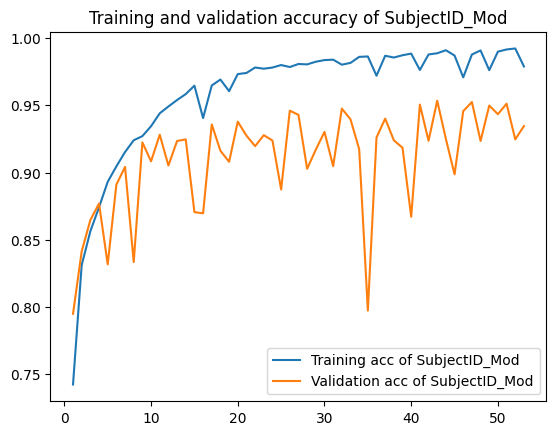

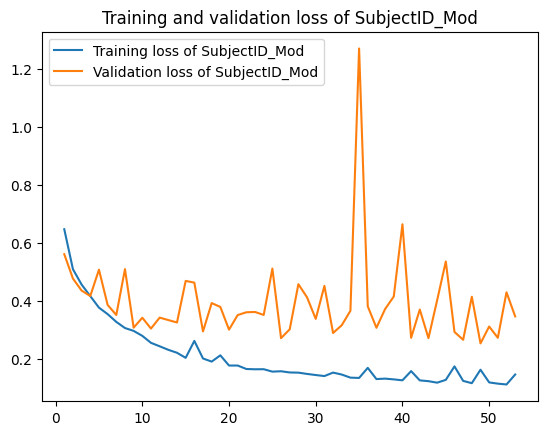

In [ ]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")

181/181 [==============================] - 2s 11ms/step


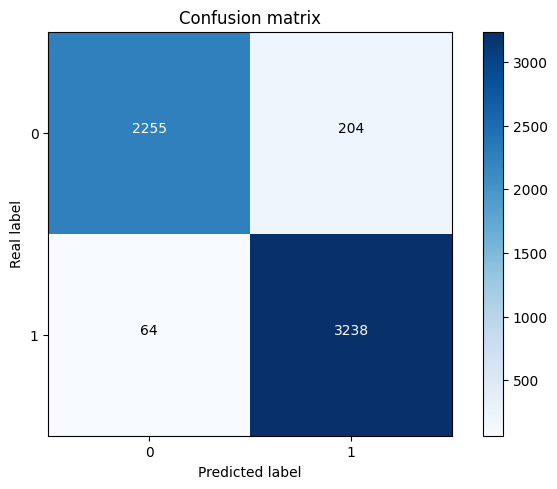

In [ ]:
# Visualize finger prediction with confusion matrix
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')


y_SubjectID_pred = model[0].predict(X_test)

y_SubjectID_pred_classes = np.argmax(y_SubjectID_pred, axis=1)

y_SubjectID_real = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_SubjectID_real, y_SubjectID_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(2))

181/181 [==============================] - 1s 8ms/step
Infomation confirm! This fingerprint is real 1


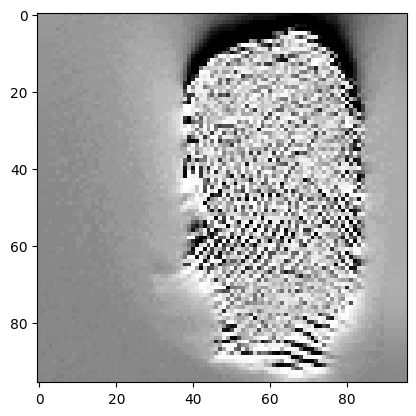

In [ ]:
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_test[rand_fp_num])

if Id_pred==Id_real:
    print("Infomation confirm! This fingerprint is real",Id_pred)
else:
    print("Oops! Prediction is wrong!")

181/181 [==============================] - 2s 8ms/step
Infomation confirm! This fingerprint belong to class:  0


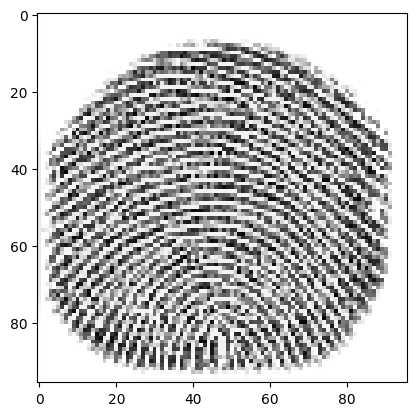

In [ ]:
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_test[rand_fp_num])

if Id_pred==Id_real:
    print("Infomation confirm! This fingerprint belong to class: ",Id_pred)
else:
    print("Oops! Prediction is wrong!")

181/181 [==============================] - 2s 8ms/step
Infomation confirm! This fingerprint belong to class:  0


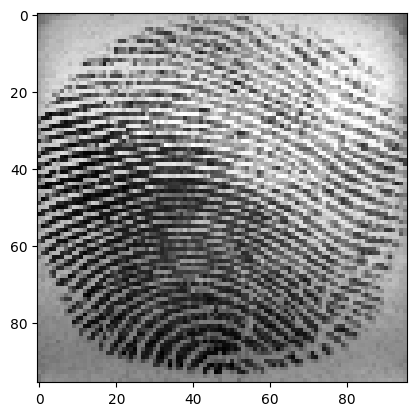

In [ ]:
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_test[rand_fp_num])

if Id_pred==Id_real:
    print("Infomation confirm! This fingerprint belong to class: ",Id_pred)
else:
    print("Oops! Prediction is wrong!")

181/181 [==============================] - 2s 11ms/step
Infomation confirm! This fingerprint belong to class:  0


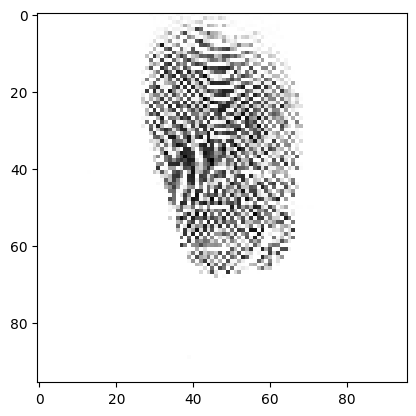

In [ ]:
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_test[rand_fp_num])

if Id_pred==Id_real:
    print("Infomation confirm! This fingerprint belong to class: ",Id_pred)
else:
    print("Oops! Prediction is wrong!")

181/181 [==============================] - 2s 11ms/step
Infomation confirm! This fingerprint belong to class:  1


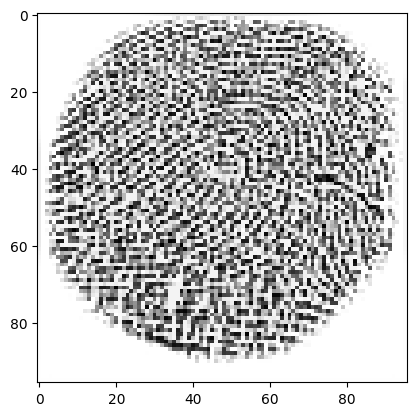

In [ ]:
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_test[rand_fp_num])

if Id_pred==Id_real:
    print("Infomation confirm! This fingerprint belong to class: ",Id_pred)
else:
    print("Oops! Prediction is wrong!")